In [67]:
import pandas as pd
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [74]:
df = pd.read_csv('upload_mse_harmonic_ANOVA.txt', header=0, sep="\t")
#df.drop('metric', axis=1, inplace=True)

In [82]:
df.head()

,embeddings,model,clusters,map_mrr
0,w2v,Baseline,1,0.2887
1,w2v,Baseline,10,0.3265
2,w2v,Baseline,25,0.3635
3,ft,Baseline,1,0.4179
4,ft,Baseline,10,0.3727


In [80]:
# unpivot data
#df = pd.melt(df.reset_index(), id_vars=['embeddings', 'model','clusters', 'metric'], value_vars=['fold_1','fold_2','fold_3','fold_4','fold_5'])
df = pd.melt(df.reset_index(), id_vars=['embeddings', 'model','clusters'], value_vars=['hm_fold1','hm_fold2','hm_fold3','hm_fold4','hm_fold5'])

In [81]:
# drop metric and variable columns since they're not useful
#df.drop('metric',axis=1,inplace=True)
df.drop('variable',axis=1,inplace=True)

# rename value to actual metric (our dependent variable)
df.rename(columns={'value':'map_mrr'}, inplace=True)

In [10]:
# show general statistics 
rp.summary_cont(df['map_mrr'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,map_mrr,225.0,0.268656,0.130924,0.008728,0.251456,0.285856


In [75]:
# filter out MFH, Cosine
#df = df.loc[df.model.isin(['Baseline', 'Asymmetric', 'Neighbour']),:]
df = df.loc[df.model.isin(['Baseline', 'MFH']),:]


In [19]:
rp.summary_cont(df.groupby(['model']))['map_mrr']

,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
Asymmetric,45,0.357424,0.035526,0.005296,0.347044,0.367805
Baseline,45,0.353667,0.038531,0.005744,0.342409,0.364925
Neighbour,45,0.358789,0.030311,0.004518,0.349933,0.367645


In [15]:
# separate the embeddings
w2v = df.loc[df['embeddings']=='w2v', :]
ft = df.loc[df['embeddings']=='ft', :]
glove = df.loc[df['embeddings']=='glove', :]


In [84]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_model(mod):
    print(f"Overall model F({mod.df_model: .0f},{mod.df_resid: .0f}) = {mod.fvalue: .3f}, p = {mod.f_pvalue: .10f}")

In [60]:
w2v.shape

(45, 4)

# Evaluate w2v results

In [20]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor
w2v_model = ols('map_mrr ~ C(clusters)*C(model)', w2v).fit()

# Seeing if the overall model is significant
print(f"Overall model F({w2v_model.df_model: .0f},{w2v_model.df_resid: .0f}) = {w2v_model.fvalue: .3f}, p = {w2v_model.f_pvalue: .10f}")

Overall model F( 8, 36) =  13.938, p =  0.0000000057


In [21]:
w2v_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     13.94
Date:                Mon, 18 Mar 2019   Prob (F-statistic):           5.71e-09
Time:                        18:45:17   Log-Likelihood:                 129.27
No. Observations:                  45   AIC:                            -240.5
Df Residuals:                      36   BIC:                            -224.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.3156      0.007     46.123      0.000       0.302       0.329
C(clusters)[T.10]                           0.0180      0.010      1.864      0.070      -0.002       0.038
C(clusters)[T.25]                           0.0438      0.010      4.531      0.000       0.024       0.063
C(model)[T.Baseline]                       -0.0279      0.010     -2.879      0.007      -0.047      -0.008
C(model)[T.Neighbour]                       0.0046      0.010      0.480      0.634      -0.015       0.024
C(clusters)[T.10]:C(model)[T.Baseline]      0.0277      0.014      2.023      0.051    -7.3e-05       0.055
C(clusters)[T.25]:C(model)[T.Baseline]      0.0313      0.014      2.286      0.028       0.004       0.059
C(clusters)[T.10]:C(model)[T.Neighbour]     0.0035      0.014      0.259      0.797      -0.024       0.031
C(clusters)[T.25]:C(model)[T.Neighbour]     0.0021      0.014      0.153      0.879      -0.026       0.030
==============================================================================
Omnibus:                        1.307   Durbin-Watson:                   0.842
Prob(Omnibus):                  0.520   Jarque-Bera (JB):                1.132
Skew:                           0.198   Prob(JB):                        0.568
Kurtosis:                       2.331   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# Creates the ANOVA table
res = sm.stats.anova_lm(w2v_model, typ= 1)
anova_table(res)

#We found that the effect of the interaction of cluster and model was insignificant. F(4, 36)=1.92, p > 0.05.
#We redo the analysis, this time testing for the effect of cluster and model in isolation.

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(clusters),0.022669,0.011335,2.0,48.423268,6.210703e-11,0.656557,0.638668
C(model),0.001634,0.000817,2.0,3.489645,4.118878e-02,0.047315,0.033529
C(clusters):C(model),0.001798,0.000449,4.0,1.920217,1.281831e-01,0.052071,0.024786
Residual,0.008427,0.000234,36.0,NaN,NaN,NaN,NaN


In [23]:
# we remove the interaction term and analyse the indepedent variables separately

w2v_model2 = ols('map_mrr ~ C(clusters)+ C(model)', w2v).fit()

print(f"Overall model F({w2v_model2.df_model: .0f},{w2v_model2.df_resid: .0f}) = {w2v_model2.fvalue: .3f}, p = {w2v_model2.f_pvalue: .8f}")

Overall model F( 4, 40) =  23.769, p =  0.00000000


In [24]:
w2v_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     23.77
Date:                Mon, 18 Mar 2019   Prob (F-statistic):           4.05e-10
Time:                        18:53:33   Log-Likelihood:                 124.91
No. Observations:                  45   AIC:                            -239.8
Df Residuals:                      40   BIC:                            -230.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3084      0.005     57.869      0.000       0.298       0.319
C(clusters)[T.10]         0.0284      0.006      4.873      0.000       0.017       0.040
C(clusters)[T.25]         0.0550      0.006      9.415      0.000       0.043       0.067
C(model)[T.Baseline]     -0.0082      0.006     -1.406      0.168      -0.020       0.004
C(model)[T.Neighbour]     0.0065      0.006      1.117      0.271      -0.005       0.018
==============================================================================
Omnibus:                        0.761   Durbin-Watson:                   0.974
Prob(Omnibus):                  0.683   Jarque-Bera (JB):                0.648
Skew:                          -0.282   Prob(JB):                        0.723
Kurtosis:                       2.833   Cond. No.                         4.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
res2 = sm.stats.anova_lm(w2v_model2, typ= 1)
anova_table(res2)
# After refitting the ANOVA model on the combination of cluster and model, very weak statistical evidence
# was found that the effect of the regularised models is significant. 
# However, the effect of clusters was significant on the harmonic mean of MAP and MRR, F(2,40)=44.342, p << 0.05
# omega^2 = 0.637

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(clusters),0.022669,0.011335,2.0,44.342770,7.089324e-11,0.656557,0.637034
C(model),0.001634,0.000817,2.0,3.195582,5.158157e-02,0.047315,0.032270
Residual,0.010225,0.000256,40.0,NaN,NaN,NaN,NaN


In [26]:
# employ Tukey's HSD to find evidence of effect in model
mc = statsmodels.stats.multicomp.MultiComparison(w2v['map_mrr'], w2v['clusters'])
mc_results = mc.tukeyhsd()
print(mc_results)

# post-hoc analysis revealed that increasing the clusters from 1 to 10, 1 to 25 and 10 to 25 all had a positive effect
# on the MAP_MRR harmonic mean when training an MSE model on word2vec features.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  1      10    0.0284  0.0135 0.0434  True 
  1      25    0.055   0.0401 0.0699  True 
  10     25    0.0265  0.0116 0.0414  True 
-------------------------------------------


# Evaluate GloVe

In [61]:
glove_model = ols('map_mrr ~ C(clusters)*C(model)', glove).fit()

# Seeing if the overall model is significant
print(f"Overall model F({glove_model.df_model: .0f},{glove_model.df_resid: .0f}) = {glove_model.fvalue: .3f}, p = {glove_model.f_pvalue: .10f}")

Overall model F( 8, 36) =  2.149, p =  0.0560267223


In [28]:
glove_model.summary()

# the overall interaction combination model was insignificant, F(8, 45) = 2.149, p < 0.05.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     2.149
Date:                Mon, 18 Mar 2019   Prob (F-statistic):             0.0560
Time:                        19:01:51   Log-Likelihood:                 111.58
No. Observations:                  45   AIC:                            -205.2
Df Residuals:                      36   BIC:                            -188.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.3593      0.010     35.442      0.000       0.339       0.380
C(clusters)[T.10]                          -0.0338      0.014     -2.359      0.024      -0.063      -0.005
C(clusters)[T.25]                          -0.0083      0.014     -0.576      0.568      -0.037       0.021
C(model)[T.Baseline]                       -0.0026      0.014     -0.183      0.856      -0.032       0.026
C(model)[T.Neighbour]                       0.0003      0.014      0.020      0.985      -0.029       0.029
C(clusters)[T.10]:C(model)[T.Baseline]      0.0013      0.020      0.063      0.950      -0.040       0.042
C(clusters)[T.25]:C(model)[T.Baseline]     -0.0042      0.020     -0.205      0.839      -0.045       0.037
C(clusters)[T.10]:C(model)[T.Neighbour]     0.0007      0.020      0.034      0.973      -0.040       0.042
C(clusters)[T.25]:C(model)[T.Neighbour]    -0.0015      0.020     -0.074      0.941      -0.043       0.040
==============================================================================
Omnibus:                        1.662   Durbin-Watson:                   0.841
Prob(Omnibus):                  0.436   Jarque-Bera (JB):                0.801
Skew:                          -0.131   Prob(JB):                        0.670
Kurtosis:                       3.599   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
# Creates the ANOVA table
res = sm.stats.anova_lm(glove_model, typ= 1)
anova_table(res)

# we tested the combination of clusters and model on the effect of mrr_map harmonic mean.
# the overall 2-way combination ANOVA was insignificant.


,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(clusters),0.008665,0.004332,2.0,8.432571,0.000992,0.317043,0.274289
C(model),0.000128,0.000064,2.0,0.124966,0.882908,0.004698,-0.032292
C(clusters):C(model),0.000041,0.000010,4.0,0.020023,0.999178,0.001506,-0.072329
Residual,0.018495,0.000514,36.0,NaN,NaN,NaN,NaN


In [64]:
glove_model2 = ols('map_mrr ~ C(clusters)', glove).fit()

print(f"Overall model F({glove_model2.df_model: .0f},{glove_model2.df_resid: .0f}) = {glove_model2.fvalue: .3f}, p = {glove_model2.f_pvalue: .8f}")

# we fitted another ANOVA model, this time exploring the effect of clusters along.  
# This was significant, F(2, 42)=9.748, p < 0.05; omega^2 = 0.280

Overall model F( 2, 42) =  9.749, p =  0.00033286


In [65]:
res2 = sm.stats.anova_lm(glove_model2, typ= 1)
anova_table(res2)


,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(clusters),0.008665,0.004332,2.0,9.74863,0.000333,0.317043,0.279968
Residual,0.018665,0.000444,42.0,NaN,NaN,NaN,NaN


In [66]:
mc = statsmodels.stats.multicomp.MultiComparison(glove['map_mrr'], glove['clusters'])
mc_results = mc.tukeyhsd()
print(mc_results)

# Post-hoc analysis revealed that increasing clusters from 1 to 10 had a significantly negative effect
# on the map_mrr harmonic mean, while increasing clusters from 10 to 25 had a positive effect.
# However, increasing the clusters from 1 to 25 had no effect on the results.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      10   -0.0332  -0.0519 -0.0145  True 
  1      25   -0.0101  -0.0288  0.0086 False 
  10     25    0.023    0.0043  0.0417  True 
---------------------------------------------


# Evaluate fastText results

In [36]:
ft_model = ols('map_mrr ~ C(clusters)*C(model)', ft).fit()

# Seeing if the overall model is significant
print(f"Overall model F({ft_model.df_model: .0f},{ft_model.df_resid: .0f}) = {ft_model.fvalue: .3f}, p = {ft_model.f_pvalue: .10f}")

Overall model F( 8, 36) =  3.556, p =  0.0039316709


In [37]:
ft_model.summary()

# the interaction combination overall model was significant on the map_nrr, F(8, 36) = 3.556, p<0.05.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     3.556
Date:                Mon, 18 Mar 2019   Prob (F-statistic):            0.00393
Time:                        21:53:27   Log-Likelihood:                 120.35
No. Observations:                  45   AIC:                            -222.7
Df Residuals:                      36   BIC:                            -206.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.4146      0.008     49.706      0.000       0.398       0.431
C(clusters)[T.10]                          -0.0382      0.012     -3.239      0.003      -0.062      -0.014
C(clusters)[T.25]                          -0.0330      0.012     -2.801      0.008      -0.057      -0.009
C(model)[T.Baseline]                       -0.0038      0.012     -0.322      0.749      -0.028       0.020
C(model)[T.Neighbour]                      -0.0074      0.012     -0.629      0.533      -0.031       0.017
C(clusters)[T.10]:C(model)[T.Baseline]      0.0080      0.017      0.480      0.634      -0.026       0.042
C(clusters)[T.25]:C(model)[T.Baseline]      0.0049      0.017      0.296      0.769      -0.029       0.039
C(clusters)[T.10]:C(model)[T.Neighbour]     0.0080      0.017      0.480      0.634      -0.026       0.042
C(clusters)[T.25]:C(model)[T.Neighbour]     0.0070      0.017      0.417      0.679      -0.027       0.041
==============================================================================
Omnibus:                        5.087   Durbin-Watson:                   0.929
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                3.931
Skew:                           0.681   Prob(JB):                        0.140
Kurtosis:                       3.492   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# Creates the ANOVA table
res = sm.stats.anova_lm(ft_model, typ= 1)
anova_table(res)

# Inspecting the ANOVA table, however revealed that neither the interaction term nor the model term 
# significant.  We retested a fresh ANOVA, focusing on just the cluster term.

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(clusters),0.009699,0.004850,2.0,13.942825,0.000033,0.432672,0.395503
C(model),0.000074,0.000037,2.0,0.106860,0.898935,0.003316,-0.027292
C(clusters):C(model),0.000122,0.000030,4.0,0.087628,0.985741,0.005439,-0.055760
Residual,0.012522,0.000348,36.0,NaN,NaN,NaN,NaN


In [39]:
ft_model2 = ols('map_mrr ~ C(clusters)', ft).fit()
print(f"Overall model F({ft_model2.df_model: .0f},{ft_model2.df_resid: .0f}) = {ft_model2.fvalue: .3f}, p = {ft_model2.f_pvalue: .8f}")

res2 = sm.stats.anova_lm(ft_model2, typ= 1)
print (res2)
anova_table(res2)

# There was a significant effect of clusters on the map_mrr score, F(2, 42) = 16.016, p << 0.05., omega^2=0.40

Overall model F( 2, 42) =  16.016, p =  0.00000677
               df    sum_sq   mean_sq          F    PR(>F)
C(clusters)   2.0  0.009699  0.004850  16.015614  0.000007
Residual     42.0  0.012718  0.000303        NaN       NaN


,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(clusters),0.009699,0.004850,2.0,16.015614,0.000007,0.432672,0.40025
Residual,0.012718,0.000303,42.0,NaN,NaN,NaN,NaN


In [40]:
mc = statsmodels.stats.multicomp.MultiComparison(ft['map_mrr'], ft['clusters'])
mc_results = mc.tukeyhsd()
print(mc_results)

# post-hoc analysis reveals that that increasing clusters from 1 to 10, and from 1 to 25 
# has a negative effect on MAP_MRR while increasing clusters from 10 to 25 has a positive negligible effect.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      10   -0.0329  -0.0483 -0.0174  True 
  1      25   -0.0291  -0.0445 -0.0136  True 
  10     25    0.0038  -0.0116  0.0192 False 
---------------------------------------------


# Evaluate difference in embeddings using only baseline 

In [41]:
all_embeddings = df.loc[df.model=='Baseline',:]

In [42]:
all_embeddings.head()
#all_embeddings.loc[, ['embeddings','clusters']]

,embeddings,model,clusters,map_mrr
1,w2v,Baseline,1,0.2887
2,w2v,Baseline,10,0.3265
3,w2v,Baseline,25,0.3635
11,ft,Baseline,1,0.4179
12,ft,Baseline,10,0.3727


In [43]:
all_model = ols('map_mrr ~ C(embeddings)*C(clusters)', all_embeddings).fit()

# Seeing if the overall model is significant
print(f"Overall model F({all_model.df_model: .0f},{all_model.df_resid: .0f}) = {all_model.fvalue: .3f}, p = {all_model.f_pvalue: .10f}")

Overall model F( 8, 36) =  19.773, p =  0.0000000000


In [44]:
all_model.summary()

# Once we could safely ignore the effect of the regularised models, we investigated the interaction of
# embeddings and cluster.s
# The overal ANOVA was significant F(8. 36) = 19.733, p << 0.05

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     19.77
Date:                Mon, 18 Mar 2019   Prob (F-statistic):           4.99e-11
Time:                        22:02:53   Log-Likelihood:                 121.11
No. Observations:                  45   AIC:                            -224.2
Df Residuals:                      36   BIC:                            -208.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.4108      0.008     50.081      0.000       0.394       0.427
C(embeddings)[T.glove]                      -0.0541      0.012     -4.667      0.000      -0.078      -0.031
C(embeddings)[T.w2v]                        -0.1231      0.012    -10.609      0.000      -0.147      -0.100
C(clusters)[T.10]                           -0.0302      0.012     -2.603      0.013      -0.054      -0.007
C(clusters)[T.25]                           -0.0281      0.012     -2.422      0.021      -0.052      -0.005
C(embeddings)[T.glove]:C(clusters)[T.10]    -0.0023      0.016     -0.143      0.887      -0.036       0.031
C(embeddings)[T.w2v]:C(clusters)[T.10]       0.0759      0.016      4.628      0.000       0.043       0.109
C(embeddings)[T.glove]:C(clusters)[T.25]     0.0157      0.016      0.956      0.346      -0.018       0.049
C(embeddings)[T.w2v]:C(clusters)[T.25]       0.1032      0.016      6.292      0.000       0.070       0.136
==============================================================================
Omnibus:                        3.321   Durbin-Watson:                   0.720
Prob(Omnibus):                  0.190   Jarque-Bera (JB):                2.513
Skew:                           0.572   Prob(JB):                        0.285
Kurtosis:                       3.179   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# Creates the ANOVA table
res = sm.stats.anova_lm(all_model, typ= 1)
anova_table(res)

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(embeddings),0.033343,0.016672,2.0,49.560111,4.575924e-11,0.510438,0.497576
C(clusters),0.002306,0.001153,2.0,3.428102,4.337089e-02,0.035307,0.024880
C(embeddings):C(clusters),0.017563,0.004391,4.0,13.052564,1.149670e-06,0.268866,0.246996
Residual,0.012110,0.000336,36.0,NaN,NaN,NaN,NaN


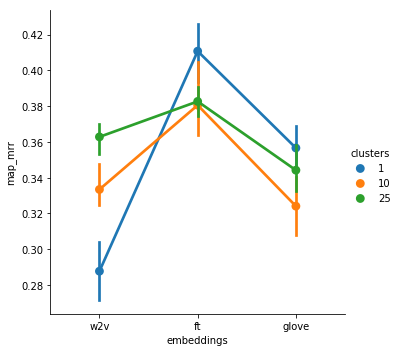

In [73]:
sns.catplot(x="embeddings", y="map_mrr", hue="clusters", kind="point", data=all_embeddings);

In [ ]:
# interaction effect is significant.  We decided to Rerun ANOVA investigating simple effect.  That is we
# run three models, checking the influence of the embeddings whilst controlling for 1, 10 and 25 clusters 
# respectively
# embeddings | c = 1
# embeddings | c = 10
# embeddings | c = 25

In [47]:
cl_1 = all_embeddings.loc[all_embeddings.clusters == 1,]
cl_1_model = ols('map_mrr ~ C(embeddings)', cl_1).fit()

# Seeing if the overall model is significant
print(f"Overall model F({cl_1_model.df_model: .0f},{cl_1_model.df_resid: .0f}) = {cl_1_model.fvalue: .3f}, p = {cl_1_model.f_pvalue: .10f}")
cl_1_model.summary()

Overall model F( 2, 12) =  52.376, p =  0.0000011789


/users/cborg/jfarrugia/py3_venv/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     52.38
Date:                Mon, 18 Mar 2019   Prob (F-statistic):           1.18e-06
Time:                        22:08:20   Log-Likelihood:                 39.795
No. Observations:                  15   AIC:                            -73.59
Df Residuals:                      12   BIC:                            -71.47
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.4108      0.009     48.200      0.000       0.392       0.429
C(embeddings)[T.glove]    -0.0541      0.012     -4.492      0.001      -0.080      -0.028
C(embeddings)[T.w2v]      -0.1231      0.012    -10.210      0.000      -0.149      -0.097
==============================================================================
Omnibus:                        0.409   Durbin-Watson:                   1.219
Prob(Omnibus):                  0.815   Jarque-Bera (JB):                0.502
Skew:                          -0.024   Prob(JB):                        0.778
Kurtosis:                       2.105   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
res = sm.stats.anova_lm(cl_1_model, typ= 1)
anova_table(res)

# the embeddings had a significant effect on single cluster, baseline models, F(2, 12)=52.376, p < 0.05, omega^2 = 0.876

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(embeddings),0.038041,0.019021,2.0,52.37647,0.000001,0.897219,0.872615
Residual,0.004358,0.000363,12.0,NaN,NaN,NaN,NaN


In [50]:
mc = statsmodels.stats.multicomp.MultiComparison(cl_1['map_mrr'], cl_1['embeddings'])
mc_results = mc.tukeyhsd()
print(mc_results)

# post-hoc analysis reveals that fastText yields a higher map_mrr than either GloVe or word2vec and that GloVE
# returns a higher score than word2vec.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  ft   glove  -0.0541  -0.0863  -0.022  True 
  ft    w2v   -0.1231  -0.1552 -0.0909  True 
glove   w2v   -0.0689  -0.1011 -0.0368  True 
---------------------------------------------


In [51]:
cl_10 = all_embeddings.loc[all_embeddings.clusters == 10,]
cl_10_model = ols('map_mrr ~ C(embeddings)', cl_10).fit()

# Seeing if the overall model is significant
print(f"Overall model F({cl_10_model.df_model: .0f},{cl_10_model.df_resid: .0f}) = {cl_10_model.fvalue: .3f}, p = {cl_10_model.f_pvalue: .10f}")
cl_10_model.summary()

Overall model F( 2, 12) =  9.471, p =  0.0034021626


/users/cborg/jfarrugia/py3_venv/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     9.471
Date:                Mon, 18 Mar 2019   Prob (F-statistic):            0.00340
Time:                        22:13:33   Log-Likelihood:                 37.642
No. Observations:                  15   AIC:                            -69.28
Df Residuals:                      12   BIC:                            -67.16
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.3806      0.010     38.687      0.000       0.359       0.402
C(embeddings)[T.glove]    -0.0565      0.014     -4.060      0.002      -0.087      -0.026
C(embeddings)[T.w2v]      -0.0471      0.014     -3.388      0.005      -0.077      -0.017
==============================================================================
Omnibus:                        4.048   Durbin-Watson:                   0.808
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                2.266
Skew:                           0.949   Prob(JB):                        0.322
Kurtosis:                       3.161   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
res = sm.stats.anova_lm(cl_10_model, typ= 1)
anova_table(res)

# the Embeddings were also significant with respect to a 10-cluster model F(2, 12)=9.471, p < 0.05, omega^2 = 0.530

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(embeddings),0.009166,0.004583,2.0,9.47125,0.003402,0.612184,0.530406
Residual,0.005806,0.000484,12.0,NaN,NaN,NaN,NaN


In [54]:
mc = statsmodels.stats.multicomp.MultiComparison(cl_10['map_mrr'], cl_10['embeddings'])
mc_results = mc.tukeyhsd()
print(mc_results)

# Once again fastText-trained models yield a significantly higher map_mrr than either GloVe or word2vec
# but in this context word2vec vectors has only a marginally stronger effect on map_mrr than GloVe.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  ft   glove  -0.0565  -0.0936 -0.0194  True 
  ft    w2v   -0.0471  -0.0842  -0.01   True 
glove   w2v    0.0093  -0.0278  0.0464 False 
---------------------------------------------


In [55]:
cl_25 = all_embeddings.loc[all_embeddings.clusters == 25,]
cl_25_model = ols('map_mrr ~ C(embeddings)', cl_25).fit()

# Seeing if the overall model is significant
print(f"Overall model F({cl_25_model.df_model: .0f},{cl_25_model.df_resid: .0f}) = {cl_25_model.fvalue: .3f}, p = {cl_25_model.f_pvalue: .10f}")
cl_25_model.summary()

Overall model F( 2, 12) =  11.406, p =  0.0016774294


/users/cborg/jfarrugia/py3_venv/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     11.41
Date:                Mon, 18 Mar 2019   Prob (F-statistic):            0.00168
Time:                        22:20:16   Log-Likelihood:                 45.842
No. Observations:                  15   AIC:                            -85.68
Df Residuals:                      12   BIC:                            -83.56
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.3827      0.006     67.198      0.000       0.370       0.395
C(embeddings)[T.glove]    -0.0385      0.008     -4.775      0.000      -0.056      -0.021
C(embeddings)[T.w2v]      -0.0198      0.008     -2.463      0.030      -0.037      -0.002
==============================================================================
Omnibus:                        0.448   Durbin-Watson:                   1.160
Prob(Omnibus):                  0.799   Jarque-Bera (JB):                0.521
Skew:                           0.316   Prob(JB):                        0.771
Kurtosis:                       2.341   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
res = sm.stats.anova_lm(cl_25_model, typ= 1)
anova_table(res)

# Lastly, embeddings have a medium effect on 25-cluster models too, F(2,12)=11.406, p<0.05, omega^2=0.58

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(embeddings),0.003699,0.001850,2.0,11.406463,0.001677,0.6553,0.581157
Residual,0.001946,0.000162,12.0,NaN,NaN,NaN,NaN


In [58]:
mc = statsmodels.stats.multicomp.MultiComparison(cl_25['map_mrr'], cl_25['embeddings'])
mc_results = mc.tukeyhsd()
print(mc_results)

# we already know from a previous test that the fastText model's performance is inhibited by training more cluster
# Indeed, we only detected that fastText has a bigger influence on GloVe but there was no detectable difference
# between fastText and word2vec and GloVe and word2vec.

# There is strong empirical evidence which suggests that - on our chosen combined dataset and metrics -  
# training a single-cluster, baseline model on fastText is the way to go.  This  challenges 
# Ustalov et al.'s assertion that regularisation has an effect on MSE model performance.  We were not able to
# confirm that even on the same word2vec embeddings they used in their experiment.  However, we do not run 
# exhaustive grid-search tests to tune the lambda regularisation parameter, instead setting to 1., which is 
# their chosen regularisation weight for re-projected regularisation.
# Fu et. al's finding were re-confirmed, despite us chaning the setup in several ways: we recast their original 
# problem as hypernym discovery; evaluated on information retrieval metrics; cross-validated the models on a 
# different dataset.  Cluster size was certainly found to improve performance on word2vec embeddings, 
# although we didn't test larger cluster sizes.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  ft   glove  -0.0385  -0.0599 -0.017  True 
  ft    w2v   -0.0198  -0.0413 0.0016 False 
glove   w2v    0.0186  -0.0029 0.0401 False 
--------------------------------------------


# Analyse performance of MSE against baseline

In [99]:
base_w2v = df.loc[(df.embeddings=='w2v'),]#&(df.clusters==1),]

w2v_naive_model = ols('map_mrr ~ C(model)*C(clusters)', base_w2v).fit()
print_model(w2v_naive_model)

Overall model F( 5, 24) =  82.223, p =  0.0000000000


In [100]:
w2v_naive_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                map_mrr   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     82.22
Date:                Tue, 19 Mar 2019   Prob (F-statistic):           2.66e-14
Time:                        18:20:54   Log-Likelihood:                 91.931
No. Observations:                  30   AIC:                            -171.9
Df Residuals:                      24   BIC:                            -163.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.2877      0.006     50.941      0.000       0.276       0.299
C(model)[T.MFH]                      -0.0424      0.008     -5.306      0.000      -0.059      -0.026
C(clusters)[T.10]                     0.0457      0.008      5.724      0.000       0.029       0.062
C(clusters)[T.25]                     0.0751      0.008      9.405      0.000       0.059       0.092
C(model)[T.MFH]:C(clusters)[T.10]    -0.0457      0.011     -4.047      0.000      -0.069      -0.022
C(model)[T.MFH]:C(clusters)[T.25]    -0.0751      0.011     -6.650      0.000      -0.098      -0.052
==============================================================================
Omnibus:                        2.480   Durbin-Watson:                   0.989
Prob(Omnibus):                  0.289   Jarque-Bera (JB):                1.211
Skew:                           0.338   Prob(JB):                        0.546
Kurtosis:                       3.715   Cond. No.                         9.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
res = sm.stats.anova_lm(w2v_naive_model, typ= 1)
anova_table(res)

,sum_sq,mean_sq,df,F,PR(>F),eta_sq,omega_sq
C(model),0.051245,0.051245,1.0,321.276622,2.119556e-15,0.738373,0.734387
C(clusters),0.007165,0.003582,2.0,22.459379,3.180428e-06,0.103234,0.098412
C(model):C(clusters),0.007165,0.003582,2.0,22.459379,3.180428e-06,0.103234,0.098412
Residual,0.003828,0.000160,24.0,NaN,NaN,NaN,NaN


In [103]:
mc = statsmodels.stats.multicomp.MultiComparison(base_w2v['map_mrr'], base_w2v['clusters'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      10    0.0229  -0.0304 0.0761 False 
  1      25    0.0376  -0.0157 0.0908 False 
  10     25    0.0147  -0.0385 0.0679 False 
--------------------------------------------
